# Avito: O que é? 

## imports

In [1]:
%matplotlib inline  
import gc
import os
import pickle
import re
import warnings

import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy as sp
from scipy.sparse import hstack, csr_matrix
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor


from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.pipeline import FeatureUnion
from rake_nltk import Rake

from helpers import save_model, load_model, limit_value

from sklearn.model_selection import RandomizedSearchCV, cross_validate


nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/arruda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/arruda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Funções de auxilio

In [2]:
def apply_uppercases_and_num_words(df, col_name):
    uppercases = []
    perc_uppercases = []
    total_num_words = []
    for text in df[col_name]:
        text = str(text)
        # remove numeros
        text = re.sub('[0-9]+', '', text)
        
        total_uppers = sum(1 for c in text if c.isupper())
        uppercases.append(total_uppers)
        total = len(text)
        if total == 0:
            perc = 0.0
        else:
            perc = total_uppers/total
        num_words = len(text.split(' '))
        total_num_words.append(num_words)

        perc_uppercases.append(perc)
    
    df[f'perc_uppercases_{col_name}'] = perc_uppercases
    df[f'num_words_{col_name}'] = total_num_words
    return df

def return_text_cols_reduced(df):
    
    try:
        description_reduced = load_from_disk('description_reduced.pkl')
    except:
        # Uses stopwords for russian from NLTK, and all puntuation characters.
        r = Rake(language='russian')

        total = df['description'].shape[0]

        verbose_step_size = int(total/10)
        description_reduced = []
        for i, description in enumerate(df['description']):
            r.extract_keywords_from_text(description)
            phrases_and_scores = r.get_ranked_phrases_with_scores()  
            if len(phrases_and_scores) <= 1:
                description_reduced.append(description)
                continue
            mean_score = np.mean([x[0] for x in phrases_and_scores])

            highest_phrases = [x[1] for x in phrases_and_scores if x[0] >= mean_score]
            reduced_description = ' '.join(highest_phrases)
            description_reduced.append(reduced_description)

            if i % verbose_step_size == 0:
                print(f'{int(i/total*100)}') 
        save_to_disk('description_reduced.pkl', description_reduced)
                
        
    return description_reduced

def transform_tfidf(col_vectorized):
    tfidf_transformer = TfidfTransformer()
    tfidf_mat = tfidf_transformer.fit_transform(vectorized_col)
    return tfidf_mat, tfidf_transformer

def vectorized_texts_and_features(df):
    stop_words = stopwords.words('russian')

    tfidf_params = {
        "token_pattern": r'\w{1,}',
        "analyzer": 'word',
        "sublinear_tf": True,
        "dtype": np.float32,
        "norm": 'l2',
        "stop_words": stop_words,
        "smooth_idf":False
    }

    vectorizer = FeatureUnion([
        ('description_reduced',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=16000,
            **tfidf_params,
            preprocessor=lambda x: x['description_reduced'])),
        ('title',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_params,
            #max_features=7000,
            preprocessor=lambda x: x['title']))
    ])


    vectorizer.fit(df[['description_reduced', 'title']].to_dict('records'))
    return vectorizer


def save_to_disk(pkl_filename, data):
    with open(pkl_filename, 'wb') as f:
        pickle.dump(data, f)
def load_from_disk(pkl_filename):
    with open(pkl_filename, 'rb') as f:
        pickle_data = pickle.load(f)
        return pickle_data
    
def get_text_transformed_and_features_name(df):
    try:
        text_transformed = load_from_disk('text_transformed.pkl')
        tfidf_features_name = load_from_disk('tfidf_features_name.pkl')
    except:
        vectorizer = vectorized_texts_and_features(df)
        text_transformed = vectorizer.transform(df.to_dict('records'))
        tfidf_features_name = vectorizer.get_feature_names()
        save_to_disk('text_transformed.pkl', text_transformed)
        save_to_disk('tfidf_features_name.pkl', tfidf_features_name)
    return text_transformed, tfidf_features_name


### Funções auxiliares pegas do notebook do victor

In [3]:
def create_model(klass, **params):
    '''Inicializa o model, com os argumentos que são passados opcionalmente
    
    Entrada:
        clf: Classe do modelo
        **params: Parâmetros a serem passados para o modelo, no momento da inicialização
        
    Saída:
        O modelo inicializado
    '''
    c = klass()
    c.set_params(**params)
    return c

In [4]:
def compute_score(klass, X_train, y_train, k=10, 
                  scoring=['neg_mean_squared_error'], rt_train=False):
    '''Realiza o treinamento e a validação, utilizando o cross-validation, e calcula as métricas desejadas
    
    Entrada:
        klass: modelo a ser treinado
        X_train: Conjunto de dados de treinamento
        y_train: resultados de cada exemplo do conjunto de dados
        k: Quantidade de folds a serem usados na cross-validation; a cada iteração (k-1) folds 
            são usados para treino e o fold remanescente é utilizado para validação
        scoring: Lista de métricas a serem calculadas para cada iteração da cross-validation
        rt_train: Decide se as métricas calculadas para o conjunto de treinamento são retornadas ou não
        
    Saída:
        scores: Dicionário contendo as métricas de cada iteração da cross-validation
        
    '''
    scores = cross_validate(klass, X_train, y_train, cv=k, scoring=scoring, return_train_score=rt_train)        
    return scores

In [23]:
def plot_metric(clf_scores, metrics):
    '''Plota métricas específicas para os diversos modelos empregados.
    
    Entrada:
        clf_scores: Dicionário com as métricas dos modelos
        metrics: Métricas a serem plotadas
        
    Saída:
        Gráfico com as métricas exibido na célula de saída
    '''
    
    warnings.filterwarnings('ignore')
    for i, metric in enumerate(metrics):
        plt.figure(figsize=(12,6))
        for score in clf_scores:
            x = range( len( clf_scores[score][metric]) )
            y = clf_scores[score][metric]
            plt.subplot(len(metrics),1,i+1)
            plt.plot(x, y, alpha=0.3)
            plt.scatter(x, y, label='{0}, média: {1}'.format(score, round(y.mean(),3)))
            plt.xticks(x)
            plt.xlabel('iteração', fontsize='large')
            plt.title('{0} na validação'.format(metric.split('_')[1]),  fontsize='large')
            plt.legend(loc='best', fontsize='large')
            plt.grid('on')
    plt.savefig('foo.png')
    plt.show()
    warnings.filterwarnings('default')


## Preparando o dataset

In [6]:
_train_complete_df = pd.read_csv('train.csv.zip', compression='zip', index_col = "item_id")
train_complete_df = _train_complete_df.copy()

_submission_df = pd.read_csv('test.csv.zip', compression='zip', index_col = "item_id")
submission_df = _submission_df.copy()

train_complete_index = train_complete_df.index
submission_index = submission_df.index

y = train_complete_df['deal_probability'].copy()
train_complete_df.drop("deal_probability",axis=1, inplace=True)

full_df = pd.concat([train_complete_df,submission_df], axis=0)
del train_complete_df, submission_df

# transformando descrições nulas em str vazias
full_df['description'] = full_df['description'].replace(np.nan, '', regex=True)

full_df['price'] = np.log(full_df['price']+0.001)
full_df['price'].fillna(-999,inplace=True)
full_df['image_top_1'].fillna(-999,inplace=True)

label_encoder = preprocessing.LabelEncoder()
cat_features = [
    'image_top_1',
    'city',
    'region',
    'parent_category_name',
    'category_name',
    'user_type',
    'param_1'
]
for feature_name in cat_features:
    print(f'encode {feature_name}')
    full_df[feature_name] = label_encoder.fit_transform(full_df[feature_name].astype(str))

full_df = apply_uppercases_and_num_words(full_df, 'description')
full_df = apply_uppercases_and_num_words(full_df, 'title')

full_df['description_reduced'] = return_text_cols_reduced(full_df)

text_transformed, tfidf_features_name = get_text_transformed_and_features_name(full_df)
    
train_complete_df = full_df.loc[train_complete_index,:].copy()
submission_df = full_df.loc[submission_index,:].copy()

del full_df
gc.collect()

train_complete_df['deal_probability'] = y

encode image_top_1
encode city
encode region
encode parent_category_name
encode category_name
encode user_type
encode param_1


## Definição das features

In [7]:
features = [
    'price', 
    'item_seq_number', 
    'image_top_1', 
    'city',
    'region',
    'parent_category_name',
    'category_name',
    'user_type',
    'param_1'
]

features.extend([
    'perc_uppercases_description',
    'perc_uppercases_title',
    'num_words_description',
    'num_words_title',
])


## Junção das features do dataset com as features de texto

In [8]:
X = hstack([
    csr_matrix(train_complete_df[features].values), 
    text_transformed[0:train_complete_index.shape[0]]
])
submission_X = hstack([csr_matrix(submission_df[features].values), text_transformed[train_complete_index.shape[0]:]])

# final_features_list = features + tfidf_features_name

### Separação entre train/test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123654)

# comparativo entre modelos

In [10]:
try:
    scores = load_from_disk('scores_xgb_lr.pkl')
except:
    scores = {}

### SVM

In [ ]:
# svm_params = {'kernel':'rbf', 'cache_size': 4000}
# svm = create_model(SVR, **svm_params)

# svm_scores = compute_score(svm, X_train, y_train)
# scores['svm'] = svm_scores

### Linear regression

In [11]:
lr = create_model(LinearRegression, **{'n_jobs':6})

lr_scores = compute_score(lr, X_train, y_train)
scores['lr'] = lr_scores

save_to_disk('score3.pkl', scores)

## Neural Network

In [ ]:
nn_params = {'hidden_layer_sizes': (100, 100, 100), 'activation': 'logistic', 'tol': 0.00001}
nn = create_model(MLPRegressor, **nn_params)


nn_scores = compute_score(nn, X_train, y_train)
scores['nn'] = nn_scores

In [ ]:
save_to_disk('score2.pkl', scores)

### XGBoost

In [27]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgb_reg = create_model(XGBRegressor, **{'reg_lambda':0, 'n_jobs':6}) 

gs = RandomizedSearchCV(xgb_reg, params, n_jobs=1)  
gs.fit(X_train, y_train) 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f427951a978>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f422cacfb38>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f42795099e8>, 'colsample_bytree...51a588>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f427951a588>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
         

In [30]:
xgb_reg_best = gs.best_estimator_
xgb_scores = compute_score(xgb_reg_best, X_train, y_train)

scores['xbg'] = xgb_scores
save_to_disk('score.pkl', scores)

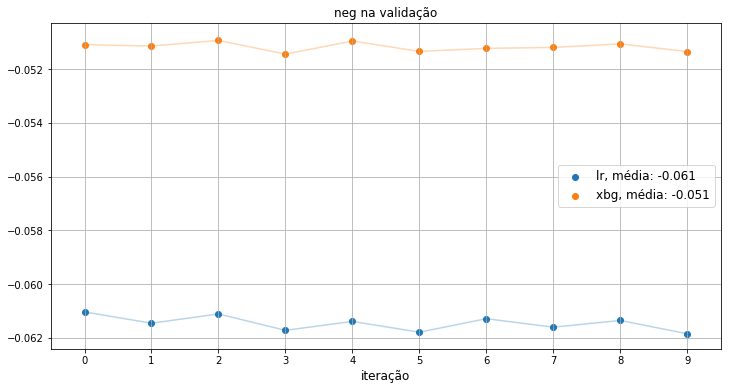

In [24]:
plot_metric(scores, ['test_neg_mean_squared_error'])

In [20]:
save_to_disk('scores_xgb_lr.pkl', scores)